<a href="https://colab.research.google.com/github/rachidboukhoudmi/Dentists-denoising./blob/main/Dentists_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Required Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Dental Radiography

/content/drive/MyDrive/Dental Radiography


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam

# Load Data

In [33]:
root_dir = "/content/drive/MyDrive/Dental Radiography/Dataset"

In [34]:
image_paths = os.listdir(root_dir)
len(image_paths)

1328

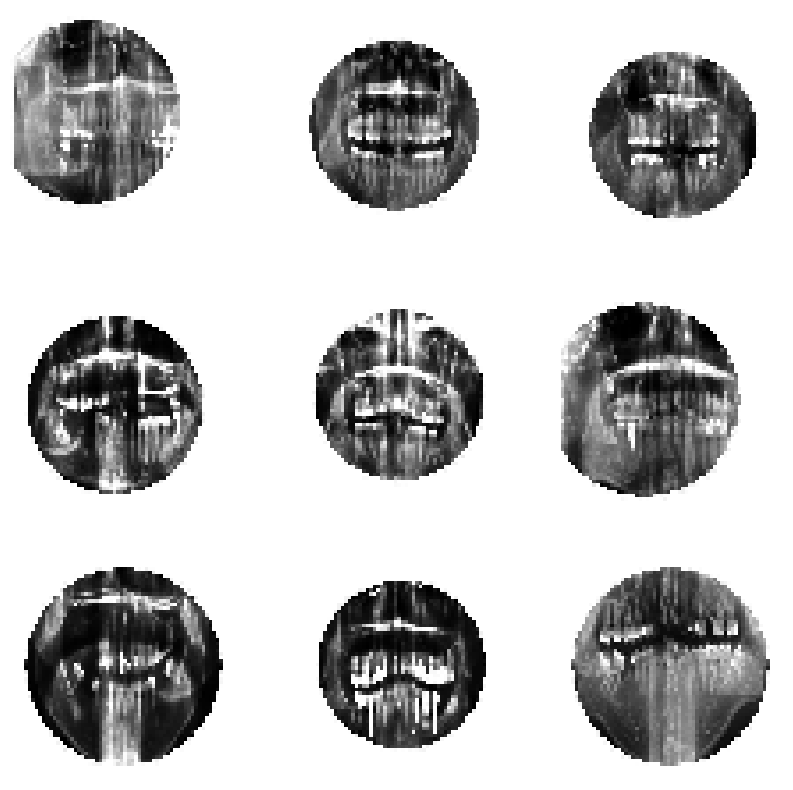

In [51]:
import os
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

image_paths = [f for f in os.listdir(root_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]  # Filter only images

images = []

for image_path in image_paths:
    img = load_img(os.path.join(root_dir, image_path), target_size=(64, 64), color_mode="grayscale")
    images.append(img)  # Append the PIL image without converting to an array

# Display a few images using matplotlib
plt.figure(figsize=(10, 10))
for i, img in enumerate(images[:9]):  # Display only the first 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
plt.show()


In [37]:
images = np.array(images)

In [38]:
type(images)

numpy.ndarray

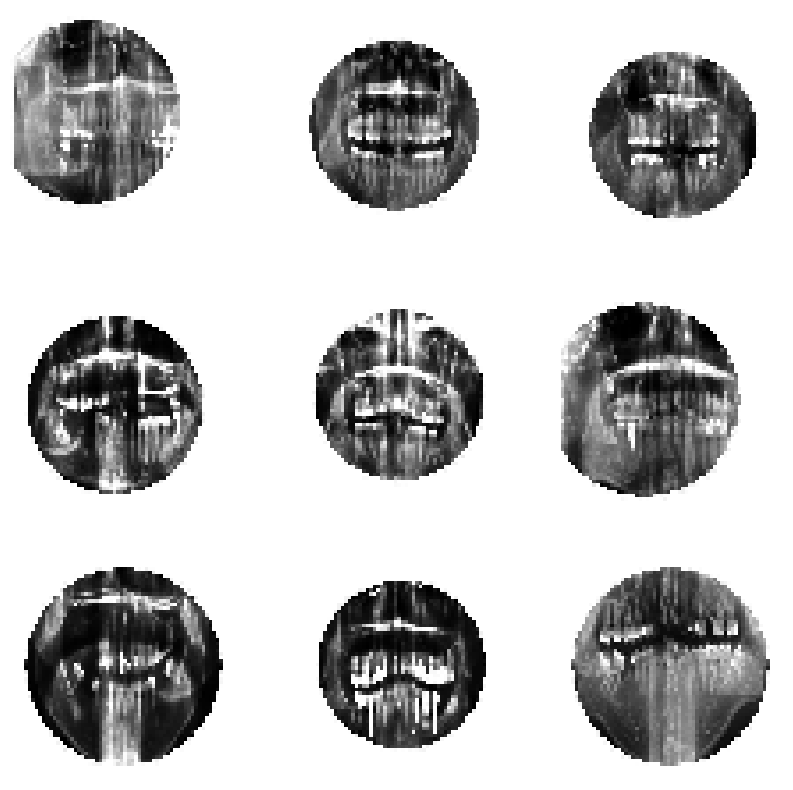

In [39]:
# plot some images

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].reshape(64, 64), cmap='gray')
    plt.axis('off')
plt.show()


In [40]:
noise_factor = 0.2

noise_images = []

for image in images:
    noisy = image + noise_factor * np.random.randn(*image.shape)  # original (64 * 64) + noise (64 * 64)
    noisy = np.clip(noisy, 0., 1.) # normalization  image /255
    noise_images.append(noisy)

In [41]:
noise_images = np.array(noise_images)

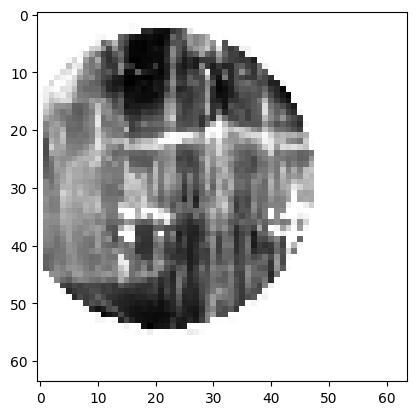

In [42]:
plt.imshow(images[0], cmap="gray")

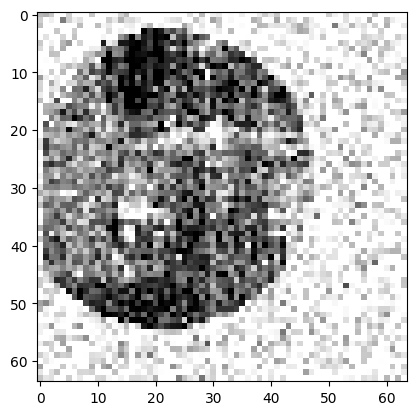

In [43]:
plt.imshow(noise_images[0], cmap="gray")

In [44]:
noise_train = noise_images[:100]
noise_test = noise_images[100:]

noise_train.shape, noise_test.shape

((100, 64, 64, 1), (83, 64, 64, 1))

In [45]:
normal_train = images[:100]
normal_test = images[100:]

normal_train.shape, normal_test.shape

((100, 64, 64, 1), (83, 64, 64, 1))

# Models

In [70]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D,MaxPool2D ,UpSampling2D, Flatten, Input
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K

def autoencoder():

    input_img = Input(shape=(64,64,1), name='image_input')

    #enoder
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), padding='same', name='pool2')(x)

    #decoder
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = UpSampling2D((2,2), name='upsample1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv4')(x)
    x = UpSampling2D((2,2), name='upsample2')(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)

    #model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    return autoencoder

In [71]:
model= autoencoder()
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)             │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1 (Conv2D)                       │ (None, 64, 64, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3 (Conv2D)                       │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ upsample1 (UpSampling2D)             │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv4 (Conv2D)                       │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ upsample2 (UpSampling2D)             │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv5 (Conv2D)                       │ (None, 64, 64, 1)           │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 112,001 (437.50 KB)

 Trainable params: 112,001 (437.50 KB)

 Non-trainable params: 0 (0.00 B)

In [72]:
model.fit(noise_train,
                 normal_train,
                 validation_data=(noise_test, normal_test),
                 epochs=200,
                 batch_size=16)

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 224ms/step - loss: 0.6365 - val_loss: 0.5696
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5394 - val_loss: 0.4565
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4174 - val_loss: 0.3670
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3575 - val_loss: 0.3545
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3444 - val_loss: 0.3457
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3331 - val_loss: 0.3381
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3244 - val_loss: 0.3344
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3233 - val_loss: 0.3305
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3233 - val_loss: 0.3275
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3117 - val_loss: 0.3271
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3167 - val_loss: 0.3261
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3147 - val_l

In [73]:
predicted = model.predict(noise_test)

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


In [74]:
from sklearn.metrics import mean_squared_error
# Calculate Mean Squared Error (MSE)
actual_values_flat = normal_test.flatten()
predicted_values_flat = predicted.flatten()

mse = mean_squared_error(actual_values_flat, predicted_values_flat)

print("Mean Squared Error:", mse)

Mean Squared Error: 0.010152706


In [75]:
evaluation = model.evaluate(noise_test, normal_test)
evaluation

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.3010


0.2999740540981293

In [76]:
def plot_predictions(test, preds):
    plt.figure(figsize=(14, 12))

    # Noise test
    for i in range(16):
        plt.subplot(4, 8, i + 1)
        plt.imshow(test[i], cmap='gray')
        plt.axis('off')
        plt.title('Noised')

    # Predicted
    for i in range(16):
        plt.subplot(4, 8, i + 17)
        plt.imshow(preds[i], cmap='gray')
        plt.axis('off')
        plt.title('Predicted')

    plt.show()

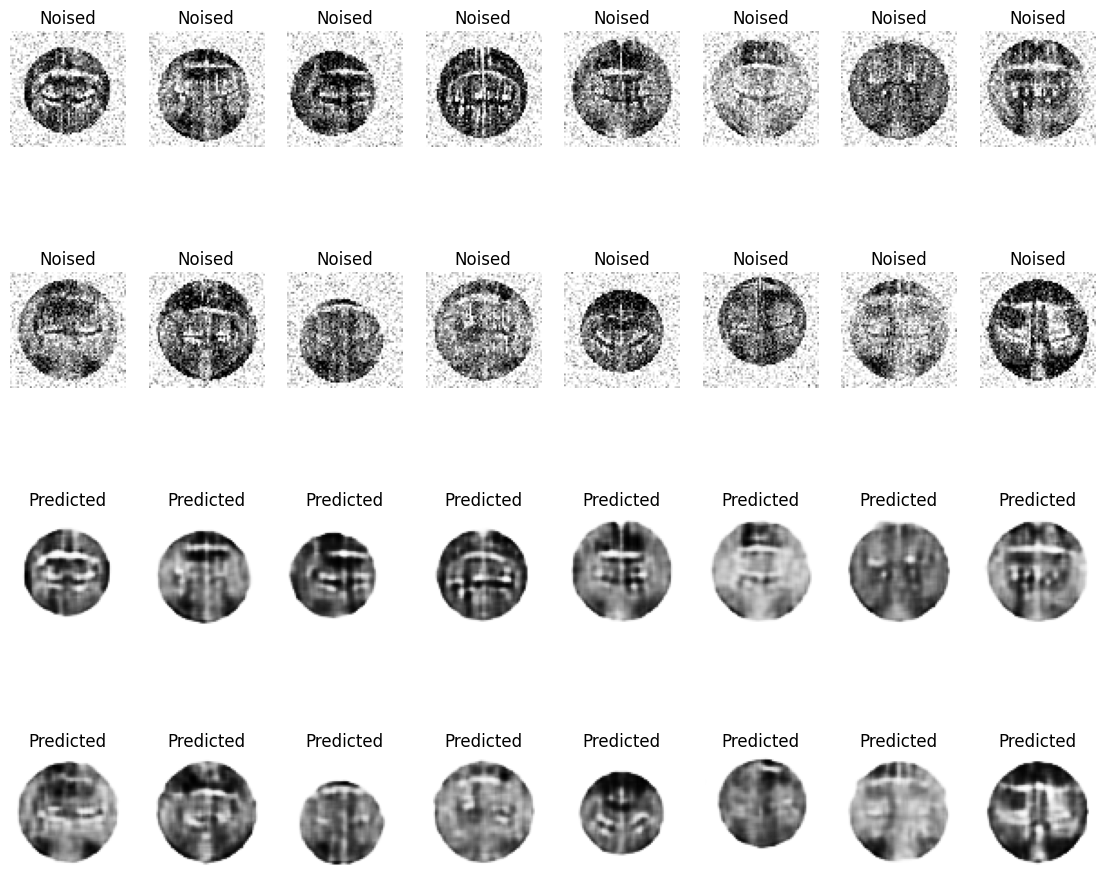

In [77]:
plot_predictions(noise_test, predicted)

In [78]:
# how to calculate the PSNR for our data using peak_signal_noise_ratio

import numpy as np
from skimage.metrics import peak_signal_noise_ratio

psnr_values = []
for i in range(len(normal_test)):
  psnr = peak_signal_noise_ratio(normal_test[i], predicted[i])
  psnr_values.append(psnr)

# Calculate the average PSNR
average_psnr = np.mean(psnr_values)
print("Average PSNR:", average_psnr)


Average PSNR: 20.060056589264917


In [79]:
# average of the RMSE and also average MSE

import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_values = []
mse_values = []

for i in range(len(normal_test)):
  mse = mean_squared_error(normal_test[i].flatten(), predicted[i].flatten())
  rmse = sqrt(mse)
  rmse_values.append(rmse)
  mse_values.append(mse)

average_rmse = np.mean(rmse_values)
average_mse = np.mean(mse_values)

print("Average RMSE:", average_rmse)
print("Average MSE:", average_mse)


Average RMSE: 0.10001526655207656
Average MSE: 0.010152705


In [80]:
input_layer = Input(shape=(64, 64, 1))

# Encoder
x = Conv2D(32, (3, 3), activation="relu", padding="same")(input_layer)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
encoded = MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = Conv2D(64, (3, 3), activation="relu", padding="same")(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

autoencoder2 = Model(input_layer, decoded)

In [81]:
autoencoder2.compile(optimizer='adam', loss='mean_squared_error')

In [82]:
autoencoder2.fit(noise_train,
                 normal_train, epochs=150, batch_size=16, shuffle=True, validation_data=(noise_test, normal_test))

Epoch 1/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 303ms/step - loss: 0.1405 - val_loss: 0.0971
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0872 - val_loss: 0.0489
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0443 - val_loss: 0.0318
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0310 - val_loss: 0.0285
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0282 - val_loss: 0.0260
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0263 - val_loss: 0.0236
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0245 - val_loss: 0.0230
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0228 - val_loss: 0.0227
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0227 - val_loss: 0.0226
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0218 - val_loss: 0.0203
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0205 - val_loss: 0.0197
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0199 - val_l

In [83]:
predicted = autoencoder2.predict(noise_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


In [84]:
evaluation = autoencoder2.evaluate(noise_test, normal_test)
evaluation

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0109


0.01066521741449833

In [85]:
# how to calculate the PSNR for our data using peak_signal_noise_ratio

import numpy as np
from skimage.metrics import peak_signal_noise_ratio

psnr_values = []
for i in range(len(normal_test)):
  psnr = peak_signal_noise_ratio(normal_test[i], predicted[i])
  psnr_values.append(psnr)

# Calculate the average PSNR
average_psnr = np.mean(psnr_values)
print("Average PSNR:", average_psnr)


Average PSNR: 19.855514949738478


In [86]:
# average of the RMSE and also average MSE

import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_values = []
mse_values = []

for i in range(len(normal_test)):
  mse = mean_squared_error(normal_test[i].flatten(), predicted[i].flatten())
  rmse = sqrt(mse)
  rmse_values.append(rmse)
  mse_values.append(mse)

average_rmse = np.mean(rmse_values)
average_mse = np.mean(mse_values)

print("Average RMSE:", average_rmse)
print("Average MSE:", average_mse)


Average RMSE: 0.10244904136784802
Average MSE: 0.0106652165


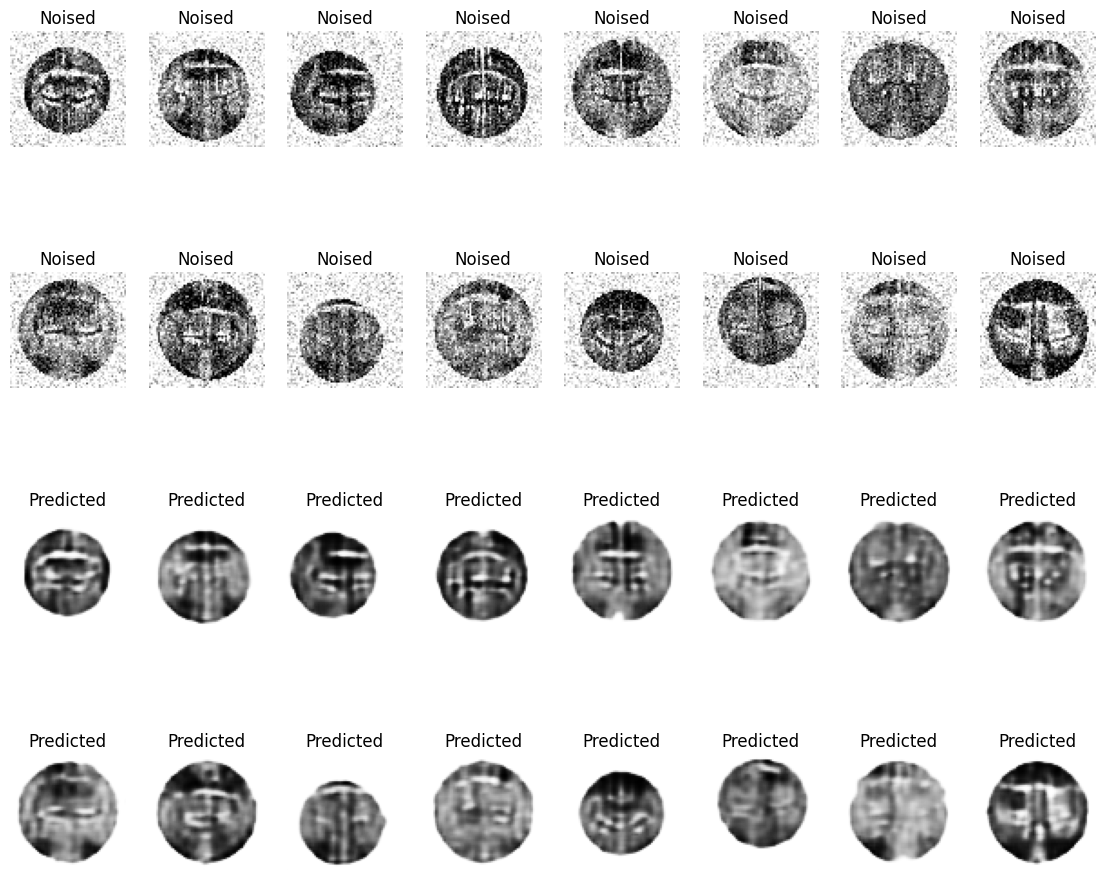

In [87]:
plot_predictions(noise_test, predicted)